In [1]:
from abc import ABC, abstractmethod
from collections import Counter, defaultdict
from dataclasses import dataclass
from enum import Enum
import functools
import itertools
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import OneHotEncoder
import torch
from typing import Dict, List, Optional, Set, Tuple, Union

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from basic_utils import (
    ALL_ROLL_TUPLES,
    Box,
    BoxCategories,
    BOX_ENUMERATION,
    RollAction,
    RollValues,
    ScoreAction,
    ScoreCard,
    roll_first,
    remove_dice,
    roll_again,
    GameState,
    ROLL_TUPLES_BY_BOX,
)
from agents import Agent, EpsilonGreedyAgent, GreedyAgent, RandomAgent, GreedyExpectedScoresAgent, GreedyExpectedScoresAgentUpperBoxWeighted
from expected_score_utils import (
    all_expected_scores_table_by_box,
    best_action_by_box_with_score_as_table,
    best_expected_scores_table_by_box,
    best_roll_action_for_box_with_score,
    best_action_by_box_with_score,
    create_expected_scores_table_one_roll,
    create_expected_scores_table_two_rolls,
    greedy_best_action,
    hit_probability_from_action,
    create_expected_scores_table_two_rolls,
)

In [20]:
best_action_by_box_with_score_as_table(RollValues(1, 2, 2, 3, 3), allowed_boxes=Box, n_rolls_left=2)

,Box,Hit Probability,Expected Score,Action Type,Dice Values
0,Chance,<NA>,21.2,Re-Roll,"(1, 2, 2, 3, 3)"
1,SmallStraight,0.518,15.5,Re-Roll,"(2, 3)"
2,FullHouse,0.556,13.9,Re-Roll,"(1,)"
3,ThreeOfAKind,0.691,12.2,Re-Roll,"(1, 2, 2)"
4,Sixes,<NA>,9.2,Re-Roll,"(1, 2, 2, 3, 3)"
5,Threes,<NA>,8.7,Re-Roll,"(1, 2, 2)"
6,Fives,<NA>,7.6,Re-Roll,"(1, 2, 2, 3, 3)"
7,LargeStraight,0.184,7.4,Re-Roll,"(1, 2, 3)"
8,Fours,<NA>,6.1,Re-Roll,"(1, 2, 2, 3, 3)"
9,Twos,<NA>,5.8,Re-Roll,"(1, 3, 3)"


In [18]:
best_action_by_box_with_score_as_table(RollValues(2, 3, 3, 4, 4), allowed_boxes=Box, n_rolls_left=1)

,Box,Hit Probability,Expected Score,Action Type,Dice Values
0,Chance,<NA>,18.5,Re-Roll,"(2, 3, 3)"
1,SmallStraight,0.556,16.7,Re-Roll,"(3, 4)"
2,Fours,<NA>,10.0,Re-Roll,"(2, 3, 3)"
3,ThreeOfAKind,0.444,8.4,Re-Roll,"(2, 3, 3)"
4,FullHouse,0.333,8.3,Re-Roll,"(2,)"
5,Threes,<NA>,7.5,Re-Roll,"(2, 4, 4)"
6,Sixes,<NA>,5.0,Re-Roll,"(2, 3, 3, 4, 4)"
7,LargeStraight,0.111,4.4,Re-Roll,"(3, 4)"
8,Fives,<NA>,4.2,Re-Roll,"(2, 3, 3, 4, 4)"
9,Twos,<NA>,3.3,Re-Roll,"(3, 3, 4, 4)"


In [ ]:
pd.DataFrame([
    (
        elem[0].name,
        "Score" if isinstance(elem[1][0], ScoreAction) else "Re-Roll",
        np.round(elem[1][1], 1),
        elem[1][0].dice_values
        if isinstance(elem[1][0], ScoreAction)
        else elem[1][0].dice_values_to_roll,
    )
    for elem in sorted(list(actions.items()), key=lambda x: x[1][1], reverse=True)
], columns=["Box", "Action Type", "Expected Score", "Dice Values"])

,Box,Action Type,Expected Score,Dice Values
0,FullHouse,Score,25.0,"(1, 1, 1, 4, 4)"
1,Chance,Re-Roll,18.5,"(1, 1, 1)"
2,Fours,Re-Roll,10.0,"(1, 1, 1)"
3,SmallStraight,Re-Roll,6.4,"(1, 1, 1, 4)"
4,ThreeOfAKind,Re-Roll,5.6,"(1, 1, 1)"
5,Sixes,Re-Roll,5.0,"(1, 1, 1, 4, 4)"
6,Fives,Re-Roll,4.2,"(1, 1, 1, 4, 4)"
7,Ones,Re-Roll,3.3,"(4, 4)"
8,Threes,Re-Roll,2.5,"(1, 1, 1, 4, 4)"
9,Twos,Re-Roll,1.7,"(1, 1, 1, 4, 4)"


In [ ]:
best_expected_scores_table_by_box()

A state in the game consists of a `ScoreCard` (score card state), `RollValues` (values of dice showing on the table), and `rolls_completed` from 1 to 3 within the turn. The `ScoreCard` contains all needed information from the previous turns. The `RollValues` just contains the values of the five dice that have been rolled at a given point.

`GameState` contains all three of these objects. It provides `possible_score_actions`, which gives the scores possible with a given set of dice values and score card state. I frame these as actions because at any time the player can choose to end their turn and score with one of these values. For convenience, they are sorted in descending order by score. `GameState` also provides `possible_actions`, which includes roll actions in addition to the `possible_score_actions`. The `re_roll` method takes dice that are specified by value and rolls again. Finally, `GameState` provides an `update_score` method, which updates the scorecard given a choice of box.

The current score can be accessed at any time by calling the `score` method of the `GameState`'s `scorecard`.

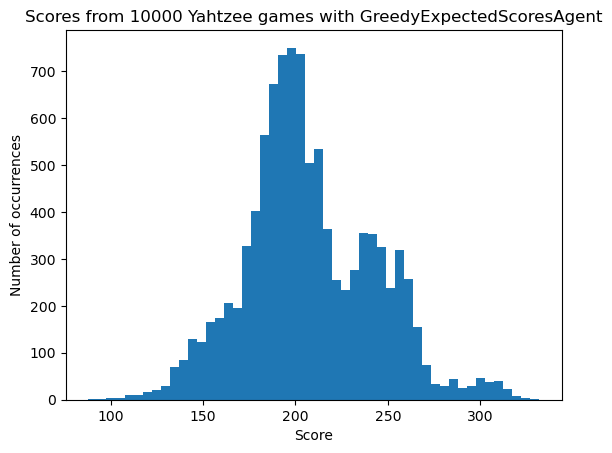

Mean score = 207
Standard deviation = 35.4
Median score = 202


In [ ]:
greedy_expected_agent_scores = GreedyExpectedScoresAgent(lookahead_rolls=1).play_games(n_games=10_000, histogram_bins=50)

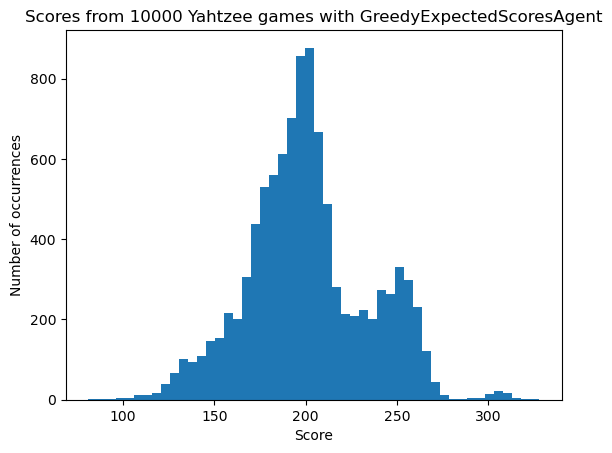

Mean score = 201
Standard deviation = 33.5
Median score = 198


In [ ]:
greedy_expected_agent_scores_2_roll_lookahead = GreedyExpectedScoresAgent(lookahead_rolls=2).play_games(n_games=10_000, histogram_bins=50)

In [ ]:
len([i for i in greedy_expected_agent_scores_2_roll_lookahead if i > 250]) / 10_000

0.0981

In [ ]:
game_state = GameState()
game_state.start_turn()

In [ ]:
action = greedy_best_action(game_state.roll_values, game_state.scorecard.unused_boxes, 3 - game_state.rolls_completed)
action

In [ ]:
game_state.take_action(action)

In [ ]:
action = greedy_best_action(game_state.roll_values, game_state.scorecard.unused_boxes, 3 - game_state.rolls_completed)
action

In [ ]:
game_state.take_action(action)

In [ ]:
action = greedy_best_action(game_state.roll_values, game_state.scorecard.unused_boxes, 3 - game_state.rolls_completed)
action

In [ ]:
class YahtzeeDeepDoubleQ(Agent):
    """
    Using the MarioAgent here as a template:
    https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
    """
    def __init__(self, state_dim, action_dim, save_dir, narrate: bool = False):
        super().__init__(narrate=narrate)
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # DNN to predict the most optimal action - we implement this in the Learn section
        self.net = YahtzeeNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving YahtzeeNet

    def choose_action(self, game_state: GameState):
        """
        Given a state, choose an epsilon-greedy action and update value of step.

        Inputs:
        state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
        Outputs:
        ``action_idx`` (``int``): An integer representing which action Mario will perform
        """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = game_state.to_array()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In [ ]:
@functools.lru_cache
def action_representation_dict() -> Dict[Union[Tuple, Box], np.ndarray]:
    result = {}
    for roll_action_indices in itertools.product(*[(0, 1) for _ in range(5)]):
        if roll_action_indices != tuple([False for _ in range(5)]):
            result[roll_action_indices] = np.array(list(roll_action_indices) + [0 for _ in range(13)], dtype=np.uint8)
    for box in Box:
        result[box] = np.array([0 for _ in range(5)] + list(np.eye(13, 13)[BOX_ENUMERATION[box], :]), dtype=np.uint8)
    return result

In [ ]:
roll_values = RollValues(1, 3, 4, 5, 5)
roll_action = RollAction(3, 5, 5)

In [ ]:
def reroll_indices(roll_values: RollValues, roll_action: RollAction) -> Tuple[int,...]:
    values = list(roll_values.values)
    mask = [0 for _ in range(5)]
    for v in roll_action.dice_values_to_roll:
        i = values.index(v)
        mask[i] = 1
        values[i] = -1
    return tuple(mask)

In [ ]:
def get_action_vector(action: Union[RollAction, ScoreAction], roll_values: Optional[RollValues] = None) -> np.ndarray:
    if isinstance(action, RollAction):
        if roll_values is None:
            raise ValueError("If the action is a RollAction, then roll_values must be provided.")
        return action_representation_dict()[reroll_indices(roll_values, action)]
    if isinstance(action, ScoreAction):
        return action_representation_dict()[action.box]

In [ ]:
def action_from_action_vector(action_vector: np.ndarray, roll_values: Optional[RollValues] = None):
    ...

In [ ]:
get_action_vector(RollAction(1, 4, 4), RollValues(1, 3, 4, 4, 5))

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
get_action_vector(ScoreAction(25, (1, 2, 3, 4, 4), Box.SmallStraight))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

Features to give the agent:
- Dice values v1, v2, v3, v4, v5
- 

In [ ]:
import re

In [ ]:
re.match(r"\b([5-9]+|\d{2,})[0-9]{2,}(\.[0-9]+)? *(GB|[Gg]igabytes?)\b", "500.5 GB")

<re.Match object; span=(0, 8), match='500.5 GB'>